In [27]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [28]:
def project_and_calc_dist(X,Y,theta,p):
    x_proj = np.dot(X, theta.T)
    y_proj = np.dot(Y, theta.T)
    qs = np.linspace(0,1,100)
    xp_quantiles = np.quantile(x_proj, qs, axis=0, method="inverted_cdf")
    yp_quantiles = np.quantile(y_proj, qs, axis=0, method="inverted_cdf")
    dist_p = np.abs(xp_quantiles - yp_quantiles)**p
    return dist_p


def sample_theta(X,num_smaples=10):
    _ , d = X.shape
    theta = np.random.randn(num_smaples,d)
    theta_norm = np.linalg.norm(theta, axis=1)
    theta_normed = theta / theta_norm[:, np.newaxis]
    return theta_normed


def mom_estimates(X):
    mean_X = np.mean(X)
    var_X = np.var(X, ddof=1)
    alpha_hat = mean_X**2 / var_X
    beta_hat = mean_X/var_X
    return alpha_hat, beta_hat


In [29]:
data = pd.read_csv("DATA.csv")

X = data.iloc[:200,1:]
Y = data.iloc[300:500,1:]

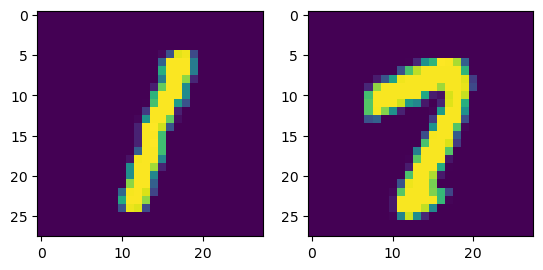

In [30]:
fig1,ax = plt.subplots(1,2)
ax[0].imshow(X.iloc[199,:].to_numpy().reshape(28,28))
ax[1].imshow(Y.iloc[199,:].to_numpy().reshape(28,28));

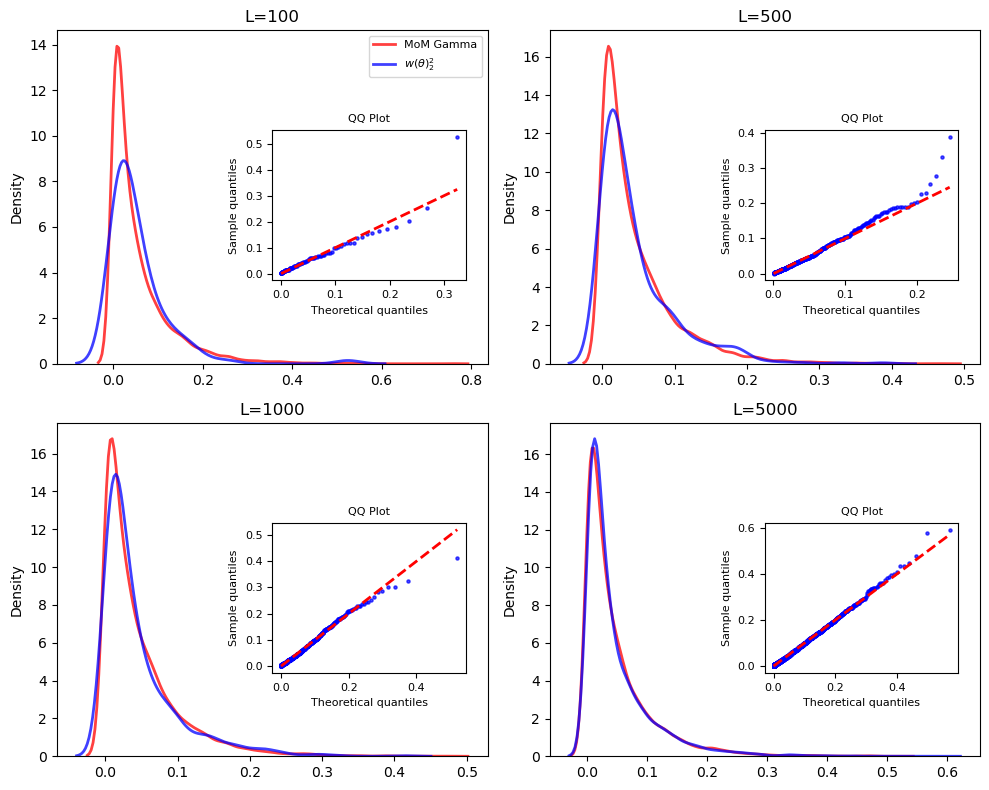

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8)) 
row = 0  

for idx, N in enumerate([100, 500, 1000, 5000]):
    THETA = sample_theta(X, N)
    w2 = project_and_calc_dist(X, Y, THETA, 2).mean(axis=0)
    
    a_hat, b_hat = mom_estimates(w2)
    
    grid_row, grid_col = divmod(idx, 2)  
    
    ax[grid_row, grid_col].set_title(f'L={N}')
    sns.kdeplot(np.random.gamma(a_hat, 1 / b_hat, 10000), ax=ax[grid_row, grid_col], lw=2, color='red', alpha=0.75, label='MoM Gamma')
    sns.kdeplot(w2, color='blue', ax=ax[grid_row, grid_col], lw=2, alpha=0.75, label='$w(\\theta)_{2}^{2}$')
    
    w2_sorted = np.sort(w2)
    start_quantile = 0.001 if N >= 1000 else 0.01
    end_quantile = 0.9999 if N >= 1000 else 0.99
    theoretical_quantiles = stats.gamma.ppf(
        np.linspace(start_quantile, end_quantile, len(w2_sorted)), a=a_hat, scale=1 / b_hat
    )
    
    inset_ax = ax[grid_row, grid_col].inset_axes([0.5, 0.25, 0.45, 0.45])  
    inset_ax.scatter(theoretical_quantiles, w2_sorted, alpha=0.7, color='blue', s=5, label='QQ Data')
    inset_ax.plot(theoretical_quantiles, theoretical_quantiles, color='red', linestyle='--', lw=2)
    inset_ax.set_title("QQ Plot",fontsize=8)
    inset_ax.set_ylabel('Sample quantiles',fontsize=8)
    inset_ax.set_xlabel('Theoretical quantiles',fontsize=8)
    inset_ax.tick_params(labelsize=8)
    
    
    if idx == 0:
        ax[grid_row, grid_col].legend(fontsize=8,loc='upper right')

fig.tight_layout()
plt.show()


In [32]:
fig.savefig('GoF_Gamma_MNIST.pdf')